In [1]:
# conda environment tf-gpu

In [2]:
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from scipy.io import savemat, loadmat
from sklearn.metrics import confusion_matrix

# import mat73
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import random
import einops
from scipy.io import loadmat
from pathlib import Path
from PIL import Image
# import PIL.Image as Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib
# matplotlib.use('Agg') # use a non-interactive backend such as Agg (for PNGs), PDF, SVG or PS.

In [3]:
# using CNN with TensorFlow core
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers, models
print("TensorFlow version:", tf.__version__)
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt
import collections
# TensorFlow version: 2.13.0

TensorFlow version: 2.17.0


In [4]:
# tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
def get_available_device():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [5]:
print(get_available_device())

['/device:CPU:0']


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Configure video data

In [7]:
path = '../image dataset/'
files = os.listdir(path)
sub_num = 1
files_head = [f for f in files if re.match(r'^sub' + str(sub_num) + '.*_1\.jpg$', f)]

In [8]:
def get_class(fname):
  return fname.split('_')[1]

In [9]:
def get_sub(fname):
  return fname.split('_')[0]

In [10]:
def integrate_video(fname, path):
    img = Image.open(path + fname).convert('CMYK')
    data = np.expand_dims(np.asarray(img), axis=0)
    for i in range(1, 7):
        fn = fname.replace('_1.jpg',f'_{i+1}.jpg')
        img_ = Image.open(path + fn).convert('CMYK')
        arr = np.expand_dims(np.asarray(img_), axis=0)
        data = np.concatenate((data, arr), axis=0)  # shape: (frame_num, width, height, channel)
    return data


In [11]:
def save_video(files, path):
    ds = []
    sub_dict = []
    class_dict = []
    for f in files:
        data = integrate_video(f, path)
        sub = get_sub(f)
        cls = get_class(f)
        ds.append(data)
        sub_dict.append(sub)
        class_dict.append(cls)

    return ds, sub_dict, class_dict

In [12]:
data, sub_dict, class_dict = save_video(files_head, path)

In [13]:
data[0].shape


(7, 369, 433, 4)

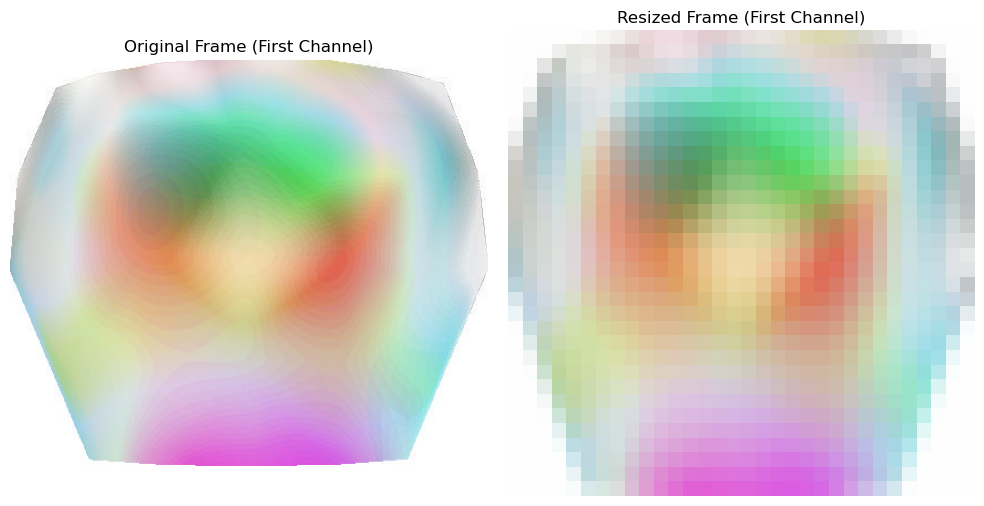

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Generate synthetic data as example (7 frames, 369x433 size, 4 channels)
original_data = data[0]

# Resize the data to (7, 32, 32, 4)
resized_data = np.zeros((7, 32, 32, 4))
for i in range(original_data.shape[0]):
    resized_data[i] = resize(original_data[i], (32, 32, 4), anti_aliasing=True)

# Plot the original and resized figure for the first frame
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original frame (only first channel for visualization)
axes[0].imshow(original_data[4, :, :, :])
axes[0].set_title("Original Frame (First Channel)")
axes[0].axis('off')

# Display the resized frame (only first channel for visualization)
axes[1].imshow(resized_data[4, :, :, :])
axes[1].set_title("Resized Frame (First Channel)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

def resize_image_size(data, target_size=(7, 32, 32, 4)):
    resized_data = []
    for one_video in data:
        resized_one_video = np.zeros(target_size)
        for i in range (one_video.shape[0]):
            resized_one_video[i] = resize(one_video[i], (target_size[1], target_size[2], target_size[3]), anti_aliasing=True)
        resized_data.append(resized_one_video)
    
    return resized_data

data = resize_image_size(data)


In [15]:
data[260].shape

(7, 32, 32, 4)

Load image: read as video frames (Tensorflow tutorial)

In [16]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [17]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [18]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 6
Num videos for class[0]: 2205


In [19]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ 
    Use for 3-class/in-subclass comparison
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [20]:
NUM_CLASSES = 2
FILES_PER_CLASS = 90   # 270 trials for each sub, 45 trials for each class per sub, 315 trials for each class in general

In [21]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['back', 'down']

In [22]:
# load data depends on subject and class

In [23]:
def get_files_per_sub_per_class(files):
  files_for_sub_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    sub_num = get_sub(fname)
    files_for_sub_for_class[(sub_num, class_name)].append(fname)
  return files_for_sub_for_class

In [24]:
files_for_sub_for_class = get_files_per_sub_per_class(files)
classes_2stage = list(files_for_sub_for_class.keys())

In [25]:
print('Num classes:', len(classes_2stage))
print('Num videos for class[0]:', len(files_for_sub_for_class[classes_2stage[0]]))

Num classes: 42
Num videos for class[0]: 315


select random train/test dataset

In [26]:
trial_dict = {'front':0, 'back':1, 'left':2, 'right':3, 'up':4, 'down':5}
label = [trial_dict[x] for x in class_dict]

In [27]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

In [28]:
print(x_train[0].shape)
print(len(x_train))
print(len(y_train))

(7, 32, 32, 4)
180
180


In [29]:
x_train = [tf.convert_to_tensor(item) for item in x_train]
x_test = [tf.convert_to_tensor(item) for item in x_test]
y_train = [tf.convert_to_tensor(item) for item in y_train]
y_test = [tf.convert_to_tensor(item) for item in y_test]

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [31]:
# batch_size = 8
# train_ds = train_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)

In [32]:
# test_batches = tf.data.experimental.cardinality(test_ds) # return the num of test batches
# val_ds = test_ds.take(test_batches//3)
# test_ds = test_ds.skip(test_batches//3)

## RCNN Model

In [418]:
import tensorflow as tf
from tensorflow.keras import layers, Model


class VGGStyleCNN(Model):
    """
    VGG-style CNN based on configuration D.
    """
    def __init__(self, img_size, n_colors):
        super(VGGStyleCNN, self).__init__()
        self.conv1 = layers.Conv2D(img_size, (3, 3), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D((2, 2))

        self.conv2 = layers.Conv2D(img_size * 2, (3, 3), activation='relu', padding='same')
        self.pool2 = layers.MaxPooling2D((2, 2))
        
        self.conv3 = layers.Conv2D(img_size * 4, (3, 3), activation='relu', padding='same')
        self.pool3 = layers.MaxPooling2D((2, 2))

        self.flatten = layers.Flatten()

    def call(self, inputs):
        print(f"Input to each ConvNet: {inputs.shape}")
        x = self.conv1(inputs)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        print(f"ConvNet output shape: {x.shape}")
        return x


class MixedLSTM1DConv(Model):
    """
    Mixed LSTM/1D-Conv network.
    """
    def __init__(self, input_shape, n_timewin, n_classes, img_size, n_colors):
        super(MixedLSTM1DConv, self).__init__()
        self.n_timewin = n_timewin
        
        # Shared CNN
        self.cnn = VGGStyleCNN(img_size, n_colors)

        # 1D Convolution for short-term temporal patterns
        self.conv1d = layers.Conv1D(filters=32, kernel_size=3, activation='relu') # 64
        self.flatten1d = layers.Flatten()

        # LSTM for long-term temporal dependencies
        self.lstm = layers.LSTM(units=32, activation='tanh', recurrent_activation='sigmoid')

        # Fully connected layers
        self.dropout1 = layers.Dropout(0.5)
        self.fc1 = layers.Dense(units=128, activation='relu')
        self.dropout2 = layers.Dropout(0.5)
        self.output_layer = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        # Process each time window frame through the shared CNN
        # print(f"Input shape: {inputs.shape}")
        cnn_outputs = [self.cnn(inputs[:, i, :, :, :]) for i in range(self.n_timewin)]
        # print(f"Shape after ConvNet: {len(cnn_outputs)}*{cnn_outputs[0].shape}")

        # Reshape the sequence
        lstm_in = tf.stack(cnn_outputs, axis=1)  # now: (batch_size, n_timewin, features)
        # conv1d_in = tf.transpose(lstm_in, perm=[0, 2, 1]) # should be (batch_size, features, n_timewin)
        # print(f"Reshaped to feed Conv1D: {conv1d_in.shape}")
        # print(f"Reshaped to feed LSTM: {lstm_in.shape}")

        # 1D Convolution for temporal patterns
        conv1d_out = self.conv1d(lstm_in)
        # print(f"Shape after Conv1D: {conv1d_out.shape}")
        conv1d_out = self.flatten1d(conv1d_out)
        # print(f"Flattened to combine with LSTM: {conv1d_out.shape}")
        # LSTM for long-term dependencies
        lstm_out = self.lstm(lstm_in)
        # print(f"Shape after LSTM: {lstm_out.shape}")

        # Merge 1D-Conv and LSTM outputs
        merged = tf.concat([conv1d_out, lstm_out], axis=-1)
        # print(f"Merged to feed FC: {merged.shape}")
        # Fully connected layers
        x = self.dropout1(merged)
        x = self.fc1(x)
        x = self.dropout2(x)
        output = self.output_layer(x)
        # print(f"Output shape: {output.shape}")
        return output


# Example usage
batch_size = 10 # 10
n_epochs = 200 # 60
input_shape = (batch_size, 7, 32, 32, 4)
n_timewin = 7
n_classes = 6
img_size = 32
n_colors = 4

# Create the model instance
model = MixedLSTM1DConv(input_shape, n_timewin, n_classes, img_size, n_colors)


In [419]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [420]:
x_train_tmp = [tensor.numpy() for tensor in x_train]
x_train_ndarray = np.stack(x_train_tmp, axis=0)
print(x_train_ndarray.shape)
y_train_ndarray = np.array([tensor.numpy() for tensor in y_train])

x_test_tmp = [tensor.numpy() for tensor in x_test]
x_test_ndarray = np.stack(x_test_tmp, axis=0)
print(x_test_ndarray.shape)
y_test_ndarray = np.array([tensor.numpy() for tensor in y_test])

(180, 7, 32, 32, 4)
(90, 7, 32, 32, 4)


In [421]:
# checkpoint_path = "./sub5_training_stride1_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_path = "./rcnn/sub"+str(sub_num)+"_training/cp.weights.h5"  # Change the file extension
checkpoint_dir = os.path.dirname(checkpoint_path)

In [422]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, # save the entire model or weights only
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 mode='max',  # max for acc, min for loss
                                                 save_best_only=True)
# history = model.fit(x = train_ds,
#                     epochs = 60,
#                     validation_data = val_ds,
#                     callbacks=[cp_callback])
history = model.fit(x=x_train_ndarray, y=y_train_ndarray, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[cp_callback])

Epoch 1/200
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)
Input to each ConvNet: (None, 32, 32, 4)
ConvNet output shape: (None, 2048)


In [423]:
# history = model.fit(x=x_train_ndarray, y=y_train_ndarray, epochs=100, batch_size=batch_size, verbose=1, validation_split=0.1)

In [424]:
model.summary()

Model: "mixed_lstm1d_conv_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg_style_cnn_59 (VGGStyleCNN)  │ ?                      │        93,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 5, 32)          │       196,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_119 (Flatten)           │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 32)             │       266,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,746,068 (6.66 MB)

 Trainable params: 582,022 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,164,046 (4.44 MB)

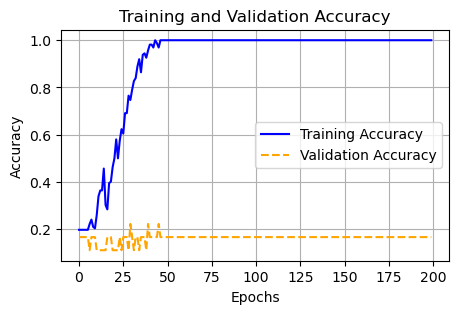

In [425]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


all use LSTM_in: overfitting, val_acc=0.33, param number=1.9m

all use CONV1d_in: overfitting, val_acc=0.11, param number=67m

learning rate = 0.0001, batch=10, val_acc=0.3889

if the training is interrupted

SUB 5

accuracy: 0.9899 - loss: 0.0952 - val_accuracy: 0.4444 - val_loss: 4.3170

In [426]:
model.load_weights(checkpoint_path)
model.evaluate(x=x_test_ndarray, y=y_test_ndarray, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1793 - loss: 2.2754 


{'accuracy': 0.15555556118488312, 'loss': 2.243734836578369}